#### libics: drivers

# VRmagic VRmC-X

Product homepage: [Imaging USB Platform](https://www.vrmagic-imaging.com/service/downloads/usb-platform-downloads)

### Imports

In [1]:
from libics.drv import drv
from libics.drv.itf import itf
import matplotlib.pyplot as plt
import time
import numpy as np

### Configuration

In [2]:
itf_cfg = {
    "protocol": itf.ITF_PROTOCOL.BINARY,
    "interface": itf.ITF_BIN.VRMAGIC,
    "device": 8514133,
}
itf_cfg = itf.ProtocolCfgBase(**itf_cfg).get_hl_cfg()

In [3]:
drv_cfg = {
    "driver": drv.DRV_DRIVER.CAM,
    "interface": itf_cfg,
    "identifier": "8514133",
    "model": drv.DRV_MODEL.VRMAGIC_VRMCX,
    "exposure_mode": drv.DRV_CAM.EXPOSURE_MODE.MANUAL,
    "exposure_time": 20e-3,
}
drv_cfg = drv.DrvCfgBase(**drv_cfg).get_hl_cfg()

### Setup

In [4]:
cam = drv.DrvBase(cfg=drv_cfg).get_drv()

### Script

##### Demo script

Reading configuration
  Image format: 1288x1032 px
  Pixel size: 5200000.0x5200000.0 µm
Setting exposure time
  Exposure time: 10.0 ms
Taking image


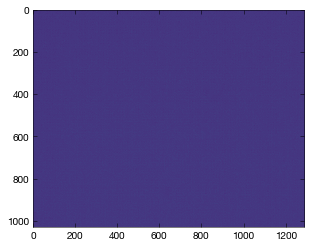

Setting exposure time
  Exposure time: 300.0 ms
Taking image


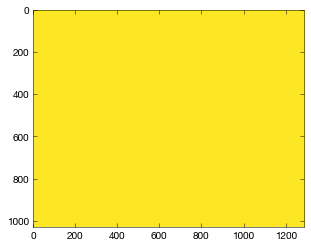

In [5]:
with cam:
    print("Reading configuration")
    cam.read_all()
    print("  Image format: {:d}x{:d} px".format(cam.cfg.pixel_hrzt_count.val, cam.cfg.pixel_vert_count.val))
    print("  Pixel size: {:.1f}x{:.1f} µm".format(cam.cfg.pixel_hrzt_size.val * 1e6, cam.cfg.pixel_vert_size.val * 1e6))
    print("Setting exposure time")
    cam.cfg.exposure_time.write(10e-3)
    print("  Exposure time: {:.1f} ms".format(cam.cfg.exposure_time.val * 1e3))
    print("Taking image")
    cam.run()
    im = cam.grab()
    cam.stop()
    plt.imshow(im, vmin=0, vmax=255)
    plt.show()
    print("Setting exposure time")
    cam.cfg.exposure_time.write(300e-3)
    cam.process()
    print("  Exposure time: {:.1f} ms".format(cam.cfg.exposure_time.val * 1e3))
    print("Taking image")
    cam.run()
    im = cam.grab()
    cam.stop()
    plt.imshow(im, vmin=0, vmax=255)
    plt.show()

In [6]:
def test_cont_acq(im):
    print("Mean signal: {:.0f}".format(np.mean(im)))
    
with cam:
    cam.cfg.exposure_mode.write(drv.DRV_CAM.EXPOSURE_MODE.CONTINUOS)
    cam.cfg.exposure_time.write(10e-3)
    cam.process()
    cam.run(callback=test_cont_acq)
    time.sleep(3)
    cam.stop()

Mean signal: 21
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22
Mean signal: 22


In [1]:
import libics.drv.itf.api.vrmusbcamapi as vrm
import ctypes as ct
import numpy as np
import matplotlib.pyplot as plt

Device 0 (8514133): free
Model: VRmC-9+/BW
Previous exposure time: 30.0 ms
New exposure time: 17.0 ms
pitch-width 2
hxwxp: 1032x1288x1290


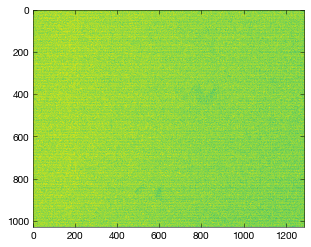

In [7]:
cam_id = 8514133

vrm.VRmUsbCamUpdateDeviceKeyList()

dev_count = vrm.VRmDWORD()
vrm.VRmUsbCamGetDeviceKeyListSize(ct.byref(dev_count))
dev_count = int(dev_count.value)

dev_key = None
dev_keys = [vrm.POINTER(vrm.VRmDeviceKey)() for _ in range(dev_count)]
[vrm.VRmUsbCamGetDeviceKeyListEntry(i, ct.byref(dev_key)) for i, dev_key in enumerate(dev_keys)]
for i, _dev_key in enumerate(dev_keys):
    print("Device {:d} ({:d}): {:s}".format(i, _dev_key.contents.m_serial, "busy" if _dev_key.contents.m_busy == 1 else "free"))
    if _dev_key.contents.m_serial == cam_id:
        dev_key = _dev_key
    else:
        vrm.VRmUsbCamFreeDeviceKey(_dev_key)

print("Model: {:s}".format(dev_key.contents.mp_product_str.data.decode('utf-8')))
dev_handle = vrm.VRmUsbCamDevice()
vrm.VRmUsbCamOpenDevice(dev_key, ct.byref(dev_handle))

####################

src_fmt = vrm.VRM_GRAY_8
vrm.VRmUsbCamSetSourceFormatIndex(dev_handle, src_fmt)


propid = vrm.VRmPropId()
propinfo = vrm.VRmPropInfo()
prop_attr_b = vrm.VRmPropAttribsB()
prop_b = vrm.VRmBOOL()
prop_attr_d = vrm.VRmPropAttribsD()
prop_d = vrm.c_double()
prop_attr_i = vrm.VRmPropAttribsI()
prop_i = ct.c_int()
prop_attr_f = vrm.VRmPropAttribsF()
prop_f = ct.c_float()
prop_attr_e = vrm.VRmPropAttribsE()
prop_e = vrm.VRmPropId()
prop_attr_s = vrm.VRmPropAttribsS()
prop_s = ct.c_char_p()

vrm.VRmUsbCamGetPropertyValueF(dev_handle, vrm.VRM_PROPID_CAM_EXPOSURE_TIME_F, ct.byref(prop_f))
prop_exposure_time = prop_f.value
print("Previous exposure time: {:.1f} ms".format(prop_exposure_time))
prop_exposure_time = (prop_exposure_time + 27) % 20
prop_f.value = prop_exposure_time
vrm.VRmUsbCamSetPropertyValueF(dev_handle, vrm.VRM_PROPID_CAM_EXPOSURE_TIME_F, ct.byref(prop_f))
vrm.VRmUsbCamGetPropertyValueF(dev_handle, vrm.VRM_PROPID_CAM_EXPOSURE_TIME_F, ct.byref(prop_f))
prop_exposure_time = prop_f.value
print("New exposure time: {:.1f} ms".format(prop_exposure_time))

####################

vrm.VRmUsbCamStart(dev_handle)
frames_dropped = vrm.VRmBOOL()
img_ready = vrm.VRmBOOL()
img = vrm.POINTER(vrm.VRmImage)()
for ii in range(1):
    vrm.VRmUsbCamLockNextImage(dev_handle, ct.byref(img), ct.byref(frames_dropped))
    height = img.contents.m_image_format.m_height
    width = img.contents.m_image_format.m_width
    pitch = img.contents.m_pitch
    print('pitch-width %s' % (pitch-width))
    im = np.array(img.contents.mp_buffer[0:height * pitch]).reshape(height, pitch)
    print("hxwxp: {:d}x{:d}x{:d}".format(height, width, pitch))
    
    vrm.VRmUsbCamUnlockNextImage(dev_handle, ct.byref(img))
r = vrm.VRmUsbCamStop(dev_handle)

####################

vrm.VRmUsbCamCloseDevice(dev_handle)
vrm.VRmUsbCamFreeDeviceKey(dev_key)


plt.imshow(im)